In [33]:
from IPython import display
from scipy.io import wavfile
import numpy as np
from numpy import fft
from matplotlib import pyplot as plt
from scipy import signal

In [11]:
def stft(data):
#     spectrogram = np.zeros((N-n, n),dtype=np.complex_)
#     for i in range(0, N-n):
#         samples = data[i : i+n ]
#         c = fft.fft(samples*window)
#         spectrogram[i, :] = c
# komentar vise test
    return signal.stft(data, nperseg = 256, window='nuttall', noverlap=224)[2]

In [12]:
def istft(spectrogram):
#     x = np.zeros(N)
#     for i in range(0, N-n):
#         x[i : i+n] += window * np.real(fft.ifft(spectrogram[i]))
    return signal.istft(spectrogram, nperseg = 256, window='nuttall', noverlap=224)[1]

In [13]:
def SSNR(x, s):
    e = np.sqrt(np.sum((np.abs(stft(x))-s)**2))
    e /= np.sqrt(np.sum(s**2))
    return -10 * np.log10(e)

In [14]:
def pc1(c):
    return stft(istft(c))

def pc2(c, s):
    return s*np.exp(1.0j*np.angle(c))

In [22]:
def GLA(s, N, iterations):
    x = np.zeros(N)

    c = s*np.exp(1.0j*np.angle(stft(x)))

    x = istft(c)

    ssnr_history = []

    for i in range(1,iterations+1):
        c = pc1(pc2(c,s))

        x = istft(c)

        ssnr = SSNR(x, s)
        if(i % (iterations/10) == 0):
            print('Reconstruction iteration: {}/{} - SSNR: {}'.format(i, iterations, ssnr))
        ssnr_history.append(ssnr)

    return x, ssnr_history

In [23]:
def FGLA(s, N, iterations, alpha = 0.99):
    x = np.zeros(N)

    c_prev = s*np.exp(1.0j*np.angle(stft(x)))
    t_prev = pc2(pc1(c_prev),s)

    x = istft(c_prev)

    ssnr_history = []

    for i in range(1,iterations+1):
        t = pc1(pc2(c_prev,s))
        c = t + alpha*(t - t_prev)

        t_prev = t
        c_prev = c

        x = istft(c)

        ssnr = SSNR(x, s)
        if(i % (iterations/10) == 0):
            print('Reconstruction iteration: {}/{} - SSNR: {}'.format(i, iterations, ssnr))
        ssnr_history.append(ssnr)

    return x, ssnr_history

In [48]:
sound_names = ["gspi.wav","cocktailparty.wav"]
alpha = 0.99
iterations = 10

x_gla_array = []
history_gla_array = []
x_fgla_array = []
history_fgla_array = []
Fs_array = []
for sound_name in sound_names:
  Fs, data = wavfile.read('/content/'+sound_name)
  Fs_array.append(Fs)
  N = data.shape[0]
  s = np.abs(stft(data))


  print("======================================================")
  print("Sound name: "+sound_name)
  print("### GLA: ")
  x_gla, history_gla = GLA(s, N, iterations)
  x_gla_array.append(x_gla)
  history_gla_array.append(history_gla)
  print("### FGLA: ")
  x_fgla, history_fgla = FGLA(s, N, iterations, alpha)
  x_fgla_array.append(x_fgla)
  history_fgla_array.append(history_fgla)

Sound name: gspi.wav
### GLA: 
Reconstruction iteration: 1/10 - SSNR: 0.08547683357559198
Reconstruction iteration: 2/10 - SSNR: 1.9181526037476506
Reconstruction iteration: 3/10 - SSNR: 2.3984643669453947
Reconstruction iteration: 4/10 - SSNR: 2.691414005689884
Reconstruction iteration: 5/10 - SSNR: 2.9974741772610307
Reconstruction iteration: 6/10 - SSNR: 3.4031151414789744
Reconstruction iteration: 7/10 - SSNR: 3.8691075264594623
Reconstruction iteration: 8/10 - SSNR: 4.259879554682498
Reconstruction iteration: 9/10 - SSNR: 4.539293380603086
Reconstruction iteration: 10/10 - SSNR: 4.729179394473598
### FGLA: 
Reconstruction iteration: 1/10 - SSNR: 1.904241052070618
Reconstruction iteration: 2/10 - SSNR: 0.411414409935797
Reconstruction iteration: 3/10 - SSNR: 2.4366832908282525
Reconstruction iteration: 4/10 - SSNR: 3.0601052593367593
Reconstruction iteration: 5/10 - SSNR: 3.753418764914951
Reconstruction iteration: 6/10 - SSNR: 4.253321577796117
Reconstruction iteration: 7/10 - SSN

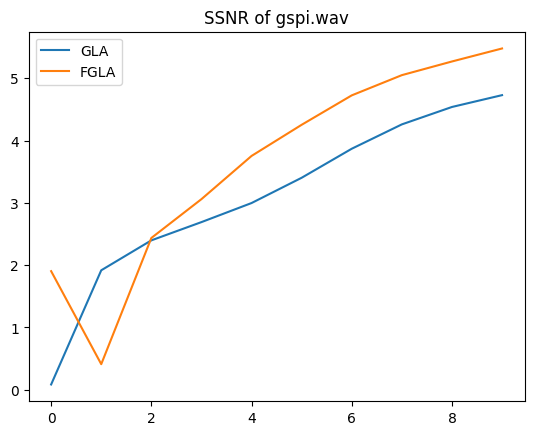

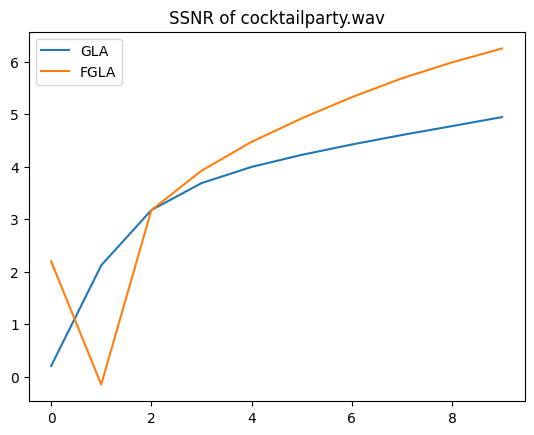

In [49]:
for i in range(len(sound_names)):
  it_vals = range(0, iterations)
  plt.title('SSNR of '+sound_names[i])
  plt.plot(it_vals, history_gla_array[i], label='GLA')
  plt.plot(it_vals, history_fgla_array[i], label='FGLA')
  plt.legend(loc='best')
  plt.show()
  display.display(display.Audio(data=x_fgla_array[i], rate=Fs_array[i]))